# BiciMAD - Machine learning predictions

Copyright © 2017 Javi Ramírez <javi.rmrz@gmail.com> | [@rameerez [tw]](http://twitter.com/rameerez) | [GitHub](http://github.com/rameerez)

This code is Open Source, released under the MIT License.

## Why/what
We've studied the actual BiciMAD users' behavior in other notebooks – but can we predict user behavior using Artificial Intelligence?

## Data sources

Apart from BiciMAD's data, we're using meteo data. All credits to [AEMET OpenData](http://www.aemet.es/es/datos_abiertos/AEMET_OpenData) (Spanish Meteorological Agency).

I tried to get hourly meteo observations for the month of March 2017, but couldn't find any source. Therefore we'll be grouping data by day.

## Definitions

In [2]:
# Data describing all bike rides
BIKE_RIDES_DATASET = './data/export_20170301_20170406.json'
# Data describing all stations (used just for getting stations' coordinates & names)
STATIONS_DATASET = './data/stations.json'

In [96]:
# AEMET's (Spanish Meteorological Agency) observations in Madrid (Retiro) for each day in March 2017
MARCH_WEATHER_DATASET = './data/march_weather_madrid_retiro.json'

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize

In [4]:
import tflearn

In [5]:
df = pd.read_json(BIKE_RIDES_DATASET, lines=True)

In [6]:
df[:3]

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,{'$oid': '58d1b3dd865e9c30d0b83c6f'},4,4,17,5,14,NaN,2303,{'$date': '2017-03-01T00:00:00.000+0100'},cc6d426ada96494d8dfe0fe0af512599f439cd9413d50c...,1,28012
1,{'$oid': '58d1b3dc865e9c30d0b83c6c'},4,2,76,22,123,NaN,876,{'$date': '2017-03-01T00:00:00.000+0100'},a81b44c3fe3c2f1e4bf723d228a0d025962228179c2e4d...,1,28009
2,{'$oid': '58d1b3dc865e9c30d0b83c6a'},5,16,163,19,166,NaN,483,{'$date': '2017-03-01T00:00:00.000+0100'},b20f0b657c493842b0aa5ebd32eed5d940c699715ee8bc...,1,28010


## Converting unplug time JSON to valid Datetime
Unfortunately the `unplug_hourTime` comes in an unnecesarily descriptive JSON. Let's convert that to a valid `Datetime` so we can do stuff like `date.month`

In [27]:
def parse_unplug_datetime(row):
    date_as_string = row['unplug_hourTime']['$date']
    return dateutil.parser.parse(date_as_string)

In [28]:
df['unplug_datetime'] = df.apply(parse_unplug_datetime, axis=1)

Yay! Valid datetimes. Let's now group by month, day and hour and plot the number of rides by hour

In [43]:
times = pd.DatetimeIndex(df.unplug_datetime)

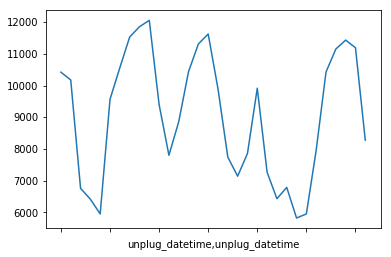

In [147]:
df.groupby([times.month, times.day])._id.count().plot()

The dataset contains data for the entire month of March and some days of April. Let's filter and get just March data.

In [91]:
march_df = df[times.month == 3]
march_times = pd.DatetimeIndex(march_df.unplug_datetime)

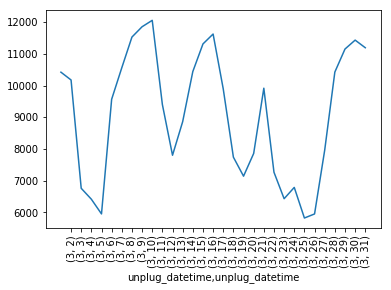

In [166]:
march_df.groupby([march_times.month, march_times.day])._id.count().plot(legend=False, rot=90, xticks=pd.Series(range(1,31)))

## Does weather affect bike usage?

In [101]:
# Caution! orient='records' is required!
march_weather_df = pd.read_json(MARCH_WEATHER_DATASET, orient='records')

In [110]:
march_weather_df[:1]

,altitud,dir,fecha,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,indicativo,nombre,prec,presMax,presMin,provincia,racha,tmax,tmed,tmin,velmedia
0,667,26,2017-03-01,11,00,00:00,16:10,06:50,3195,"MADRID, RETIRO","0,0","944,2","940,5",MADRID,"6,9","16,0","10,6","5,2","1,1"


Well, shit. Is nobody going to record their data in a freaking valid way? Those "float" numbers are NOT numbers – they are strings! The only valid float separator is a point `.`, not a comma `,`. Time to clean (again) our data:

In [120]:
def comma_string_to_float(float_string):
    return float(float_string.replace(".","").replace(",","."))

#TO-DO!!!!!!!! parse the rest of the columns
def parse_rain_float_in_table(row):
    return comma_string_to_float(row['prec'])

In [116]:
march_weather_df['rain'] = march_weather_df.apply(parse_rain_float_in_table, axis=1)

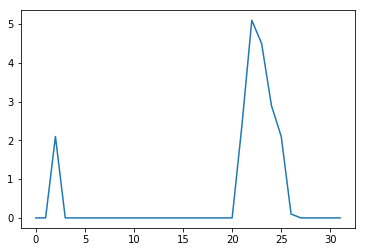

In [119]:
march_weather_df.rain.plot()

Interesting! Rain seems to be the inverse of usage! Let's recall:

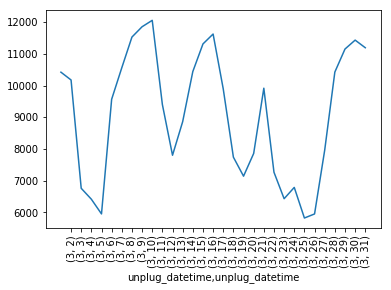

In [167]:
march_df.groupby([march_times.month, march_times.day])._id.count().plot(legend=False, rot=90, xticks=pd.Series(range(1,31)))